
Step 1: Loading CSV files with sampling...
Found 169 CSV files.
Data loaded. Shape after sampling and cleaning: (4668657, 47)
Binary labels created. Unique classes: ['malicious' 'benign']
Training Random Forest model for binary classification...

=== Binary Classification (Benign vs Malicious) Evaluation ===
Accuracy : 0.9973675530023605
Recall   : 0.9983162397850052
Precision: 0.998986869922001
F1-score : 0.9986514422654892

Classification Report:
               precision    recall  f1-score   support

      benign       0.93      0.96      0.95     22082
   malicious       1.00      1.00      1.00    911650

    accuracy                           1.00    933732
   macro avg       0.97      0.98      0.97    933732
weighted avg       1.00      1.00      1.00    933732



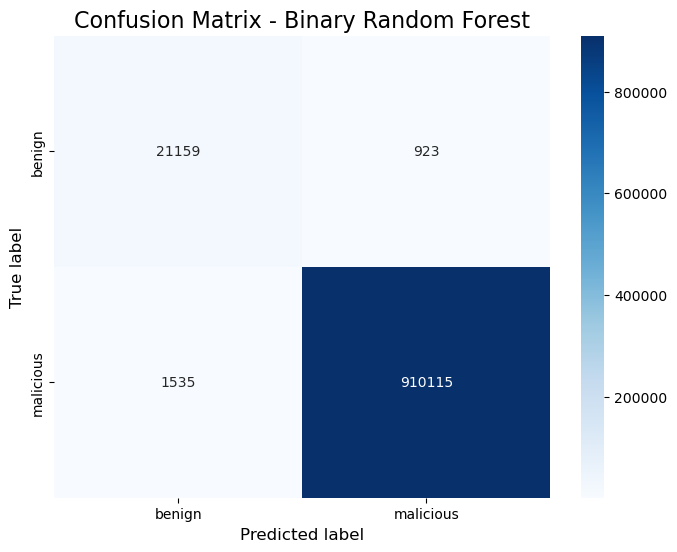


Top 20 important features:
1. IAT: 0.1519
2. urg_count: 0.1422
3. rst_count: 0.1275
4. flow_duration: 0.1072
5. Duration: 0.0608
6. Number: 0.0511
7. Header_Length: 0.0454
8. Weight: 0.0402
9. Variance: 0.0368
10. Rate: 0.0294
11. Srate: 0.0275
12. AVG: 0.0155
13. HTTPS: 0.0151
14. Radius: 0.0144
15. Covariance: 0.0142
16. Max: 0.0136
17. Protocol Type: 0.0117
18. Tot size: 0.0116
19. ack_flag_number: 0.0114
20. Magnitue: 0.0110


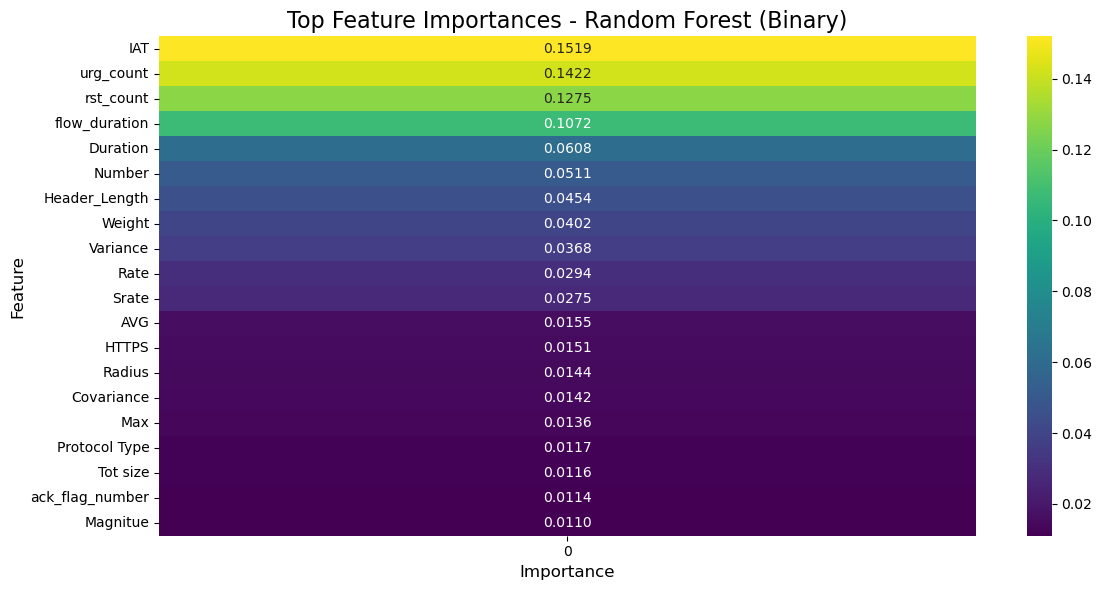



Binary Classification Analysis Complete.


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns


RANDOM_STATE = 42                      
DATASET_PATH = '/Users/bodapati/Downloads/wataiData 3/csv/CICIoT2023'  
SAMPLING_FRACTION = 0.1                
TOP_N_FEATURES = 20                    


def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=16)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()


print("\nStep 1: Loading CSV files with sampling...")
all_files = glob.glob(os.path.join(DATASET_PATH, "*.csv"))  
if not all_files:
    raise FileNotFoundError(f"No CSV files found in {DATASET_PATH}")
print(f"Found {len(all_files)} CSV files.")

# Read each CSV, sample rows, and append to list
df_list = []
for file in all_files:
    df = pd.read_csv(file).sample(frac=SAMPLING_FRACTION, random_state=RANDOM_STATE)
    df_list.append(df)

# Combine all sampled CSVs into a single DataFrame
main_df = pd.concat(df_list, ignore_index=True)

# Remove empty columns, missing rows, and duplicate rows
main_df.dropna(axis=1, how='all', inplace=True)
main_df.dropna(inplace=True)
main_df.drop_duplicates(inplace=True)
print(f"Data loaded. Shape after sampling and cleaning: {main_df.shape}")


# STEP 2: MAP LABELS TO BINARY

# Keep only rows with 'label' column present
main_df.dropna(subset=['label'], inplace=True)

# Map original labels to binary: BenignTraffic -> 'benign', all else -> 'malicious'
main_df['label_binary'] = main_df['label'].apply(lambda x: 'benign' if x == 'BenignTraffic' else 'malicious')
print(f"Binary labels created. Unique classes: {main_df['label_binary'].unique()}")


# STEP 3: FEATURE PREPARATION

# Columns to drop for modeling (non-numeric / target / identifiers)
cols_to_drop = ['label', 'label_binary', 'ts']
existing_cols_to_drop = [col for col in cols_to_drop if col in main_df.columns]

# X = numeric features only
X = main_df.drop(columns=existing_cols_to_drop).select_dtypes(include=np.number)

# y = target labels
y = main_df['label_binary']

# Encode binary labels to 0/1
le = LabelEncoder()
y_encoded = le.fit_transform(y)  


# STEP 4: TRAIN-TEST SPLIT & SCALING

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# STEP 5: RANDOM FOREST MODEL TRAINING

print("Training Random Forest model for binary classification...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)


# STEP 6: EVALUATION

y_pred = rf_model.predict(X_test_scaled)

print("\n=== Binary Classification (Benign vs Malicious) Evaluation ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred, average='binary', zero_division=0))
print("Precision:", precision_score(y_test, y_pred, average='binary', zero_division=0))
print("F1-score :", f1_score(y_test, y_pred, average='binary', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


# STEP 7: CONFUSION MATRIX

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=le.classes_, title='Confusion Matrix - Binary Random Forest')


# STEP 8: FEATURE IMPORTANCE
importances = rf_model.feature_importances_       
indices = np.argsort(importances)[::-1]           

print("\nTop 20 important features:")
for i in range(min(TOP_N_FEATURES, len(feature_names))):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")


importance_df = pd.DataFrame([importances], columns=feature_names)

top_features = importance_df.T.sort_values(by=0, ascending=False).head(TOP_N_FEATURES)


plt.figure(figsize=(12, 6))
sns.heatmap(top_features, annot=True, cmap='viridis', fmt=".4f")
plt.title("Top Feature Importances - Random Forest (Binary)", fontsize=16)
plt.ylabel("Feature", fontsize=12)
plt.xlabel("Importance", fontsize=12)
plt.tight_layout()
plt.show()

print("\n\nBinary Classification Analysis Complete.")